In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import keras
import tensorflow.keras.backend as K
import model_function

In [3]:
# Create a 5x5 array filled with zeros
five_array = np.zeros((5, 5), dtype=float)

# Fill the array to represent the shape of number 5
five_array[0, :] = 1  
five_array[1, 0] = 1  
five_array[2, :] = 1  
five_array[3, -1] = 1  
five_array[4, :] = 1 


two_array = np.zeros((5, 5), dtype=float)
two_array[0, 1:-1] = 1  
two_array[1, -1] = 1 
two_array[1, 0] = 1  
two_array[2, -2] = 1  
two_array[3, 1:-2] = 1
two_array[4,:] = 1  


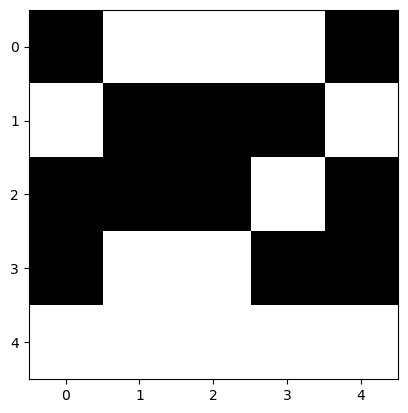

In [4]:
plt.imshow(two_array, cmap='gray')

Set Parameters

In [103]:
#times in ms
base_on_time= 50
on_time = 50
off_time= 20
#current in mA
baseline_current = 1.0
model_input_array = np.zeros((1,3), dtype=float)

Load ML model

In [6]:
load = True
model_path ='models/2024-04-17_12-35-13_single_step_41/model.h5'

if load:
    model = keras.models.load_model(model_path)

For each row in image, generate pulse sequence

In [89]:
def number_to_pulse_train_generator(input:np.ndarray, base_on_time:int, on_time:int, off_time:int, modulation:float)->np.ndarray:
    '''Pulse train output is a sequence of D*2 integers alternating between on pulse duration and off pulse duration'''
    
    output_current = np.zeros_like(input)
    output_signal= np.zeros((input.shape[0],input.shape[0]*2))
    for irow, row in enumerate(input):
        for icol, value in enumerate(row):
            if icol ==0:
                on = base_on_time+on_time*(value*modulation)
                off = off_time+on_time*((1-value)*modulation)
                model_input_array[0,:] = np.array([baseline_current, on, off])
                output_signal[irow,2*icol]= on
                output_signal[irow,2*icol+1]= off
                output_current[irow,icol]= model.predict(model_input_array, verbose=0)              
            else:    
                on = base_on_time+on_time*(value*modulation)
                off = off_time+on_time*((1-value)*modulation)            
                model_input_array[0,:] = np.array([output_current[irow,icol-1], on, off]) 
                output_signal[irow,2*icol]= on
                output_signal[irow,2*icol+1]= off
                output_current[irow,icol]= model.predict(model_input_array, verbose=0)
                
    return output_current, output_signal

In [114]:
def draw_pulse_train_outcome(source_image,current,pulse_train):
    fig, axs = plt.subplots(pulse_train.shape[0],sharex= True, figsize=(5,5))
    for irow, row in enumerate(pulse_train):
        y_values = []
        for i,value in enumerate(row):
            if i%2==0:
                y_values.extend([1]*int(value))
            else:
                y_values.extend([0]*int(value))
        axs[irow].fill_between(range(len(y_values)),y_values, linestyle='-', label=irow)  
        # plt.legend()
    fig.supxlabel('Time (ms)')
    fig.supylabel('Signal')
    fig.suptitle('Device input signal per row')



    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    axs[0].imshow(source_image, cmap='gray')
    axs[1].imshow(current, cmap='inferno')
    axs[0].set_xlabel('Column count')
    axs[1].set_xlabel('Pulse count')
    axs[0].set_ylabel('Row count')
    axs[1].set_ylabel('Row count')
    axs[0].set_title('Source image')
    axs[1].set_title('Current heatmap')
    plt.xlabel('Pulse count')
    plt.ylabel('Row count')

    plt.figure(figsize=(5, 5))
    for i, row in enumerate(current):
        plt.plot(range(len(row)),row, marker='o', linestyle='-', label=i)  
    # plt.legend()
    plt.xlabel('Pulse count')
    plt.ylabel('Current (mA)')
    plt.title('Device output per row signal')

    
        

In [115]:
current_two,pulse_train_two = number_to_pulse_train_generator(two_array, base_on_time,on_time, off_time, modulation=1)


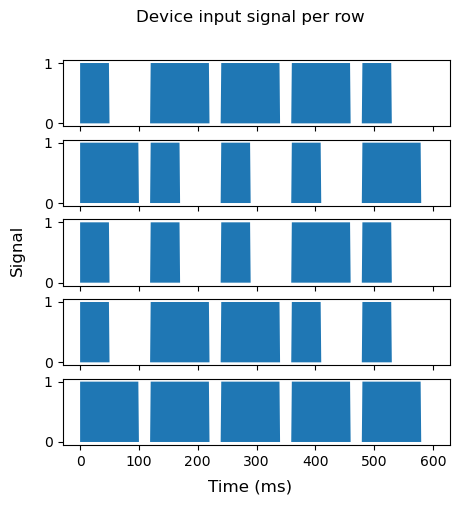

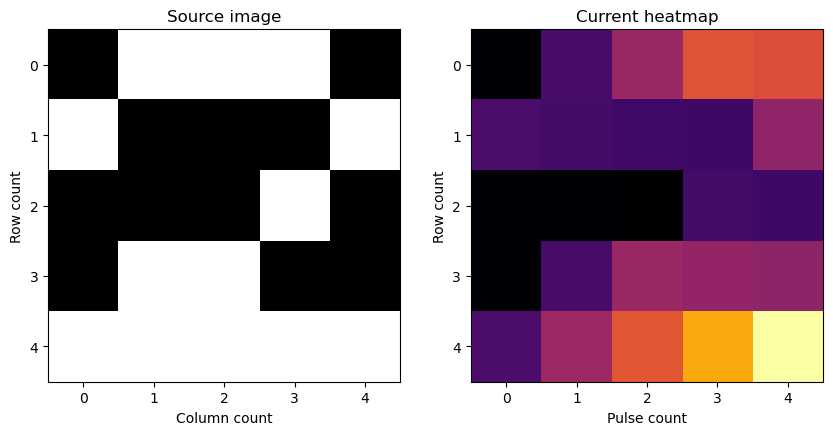

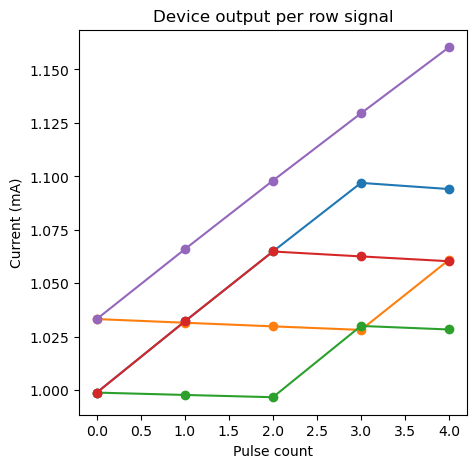

In [116]:
draw_pulse_train_outcome(two_array,current_two,pulse_train_two)

In [95]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)



In [118]:
#try on MNIST dataset
source_image_1 = x_train[24,::1,::1]/255
current_1,pulse_train_1 = number_to_pulse_train_generator(source_image_1, base_on_time, on_time, off_time, modulation=1)


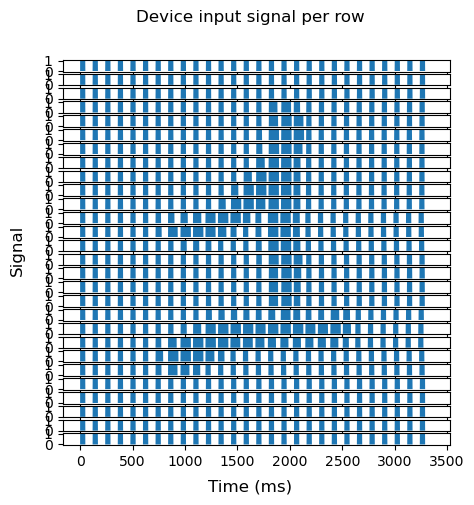

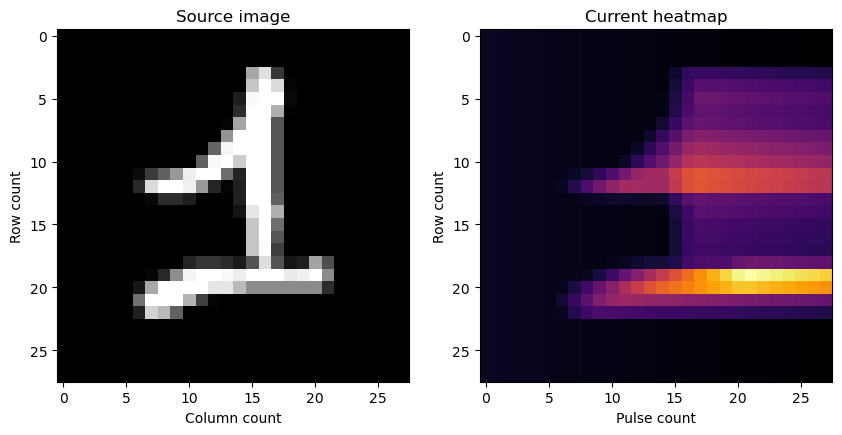

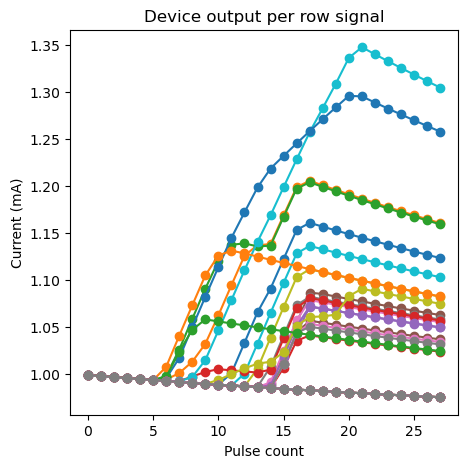

In [119]:
draw_pulse_train_outcome(source_image_1,current_1,pulse_train_1)

In [120]:
source_image_2 = x_train[26345,::1,::1]/255
current_2,pulse_train_2 = number_to_pulse_train_generator(source_image_2, base_on_time, on_time, off_time, modulation=1)

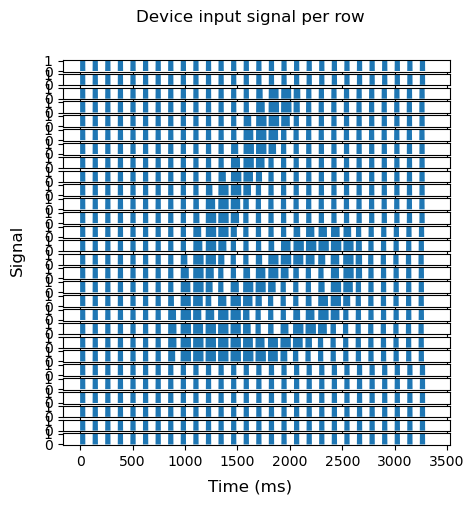

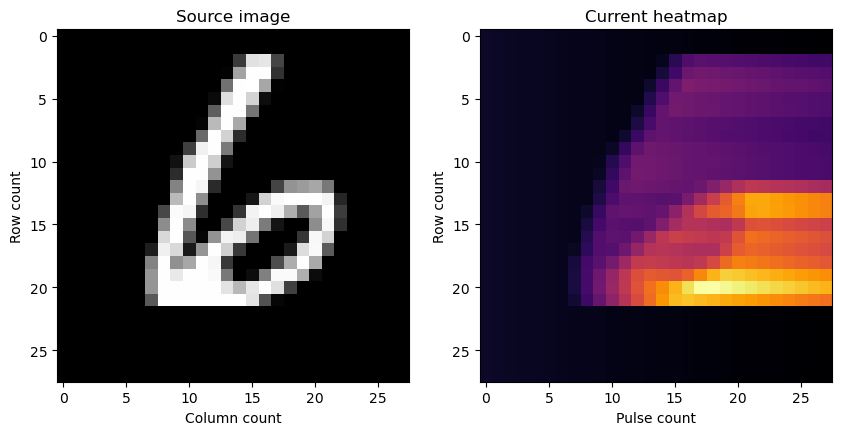

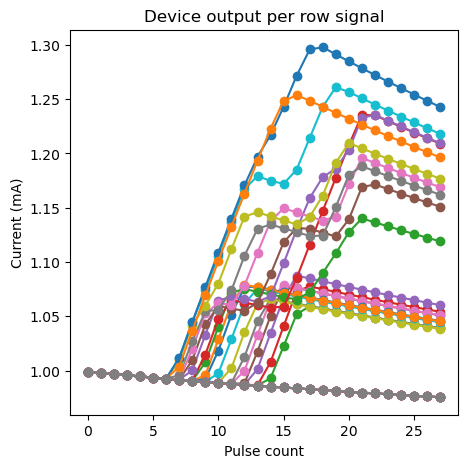

In [121]:
draw_pulse_train_outcome(source_image_2,current_2,pulse_train_2)